# Parameters from 01198000 to 01181000

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib notebook
import seaborn as sns
import os
import copy

In [2]:
os.chdir('..')

In [3]:
from tools.train_lumped_models import build_train_CemaneigeGR4J
from tools.weather import preprocess_weather
from tools.metrics import calc_nse, calc_kge

In [4]:
from models.RRMPG.rrmpg.models import CemaneigeGR4J

## Set 01181000 as an example: in cfsm

In [5]:
# load entire parameters trained before
parameters = pd.read_csv('data/HydroSimilarStations/parameters/Param_Metrics_RRMPG_CGR4J.txt', dtype={'Gauges':str}, index_col=0)
parameters

Datum        Lat        Lon  Drainage_area_sqmile       CTG  \
Gauges                                                                       
01175670  191.841120  42.264814 -72.004242                  8.81  0.061642   
01181000  116.720112  42.237312 -72.895654                 94.00  0.170645   
01111500   54.626256  41.996487 -71.562008                 91.20  0.056554   
01097300   46.997112  42.512593 -71.404228                 12.80  0.102157   
01198000  210.113880  42.192908 -73.391231                 51.00  0.031988   
01174565  164.421312  42.455089 -72.381752                 12.60  0.047885   
01082000  222.885000  42.862584 -71.959246                 68.10  0.018245   
01095220  121.700544  42.410925 -71.791183                 29.10  0.034532   
01176000  118.676928  42.182316 -72.263691                150.00  0.078760   

                Kf          x1        x2          x3        x4   NSE_cal  \
Gauges                                                                     
01175670  5.258350  239.824213 -0.485603  116.006261  1.642470  0.735255   
01181000  2.729069   94.151210  0.572261   50.715876  1.437586  0.486183   
01111500  5.644943  428.198252  0.040318  100.683382  2.016601  0.860473   
01097300  5.527557  422.341330 -1.219657  105.883857  2.089392  0.823000   
01198000  8.551404  114.354380 -0.724973  109.058609  1.324393  0.662829   
01174565  4.331532  235.246262 -0.099055   50.079084  1.537207  0.686872   
01082000  5.499495  308.060126  0.290106   85.131785  1.795976  0.791677   
01095220  3.616543  284.370667  1.188157   63.547844  1.823649  0.748565   
01176000  7.637186  126.835921 -1.013071  474.826997  2.454783  0.764669   

           NSE_val  NSE_total   KGE_cal   KGE_val  KGE_total  
Gauges                                                        
01175670  0.364704   0.683304  0.831180  0.627923   0.799954  
01181000  0.638502   0.511795  0.690882  0.793978   0.725558  
01111500  0.796452   0.851006  0.897560  0.861938   0.893322  
01097300  0.733398   0.814945  0.864736  0.697302   0.854759  
01198000  0.567330   0.651800  0.799327  0.722042   0.790977  
01174565  0.504762   0.655792  0.822542  0.747055   0.809615  
01082000  0.621093   0.768568  0.884505  0.677725   0.857349  
01095220  0.672581   0.734845  0.774250  0.789411   0.783005  
01176000  0.736625   0.760833  0.830196  0.787114   0.823995

In [9]:
weather_type = 'daymet'

# Gauge info
gauge = '01181000'
HS_gauge = '01198000' # hydrological similar gauge
gauge_lat = parameters.loc[gauge, 'Lat']
gauge_height = parameters.loc[gauge, 'Datum'] # m
gauge_area = parameters.loc[gauge, 'Drainage_area_sqmile'] # sqmile


# Load weather
weather_df_raw = pd.read_csv('data/HydroSimilarStations/daymet_streamflow/{gauge}.csv'.format(gauge = gauge), 
                             index_col=0, parse_dates=True).dropna()
obsflow = weather_df_raw.iloc[:, -1] * 35.3146667/gauge_area# m3/s to cfsm
weather_df = preprocess_weather(weather_df_raw.iloc[:, :-1], weather_type, gauge_lat)

# Load model parameter
model = CemaneigeGR4J()

# different parm obtaining strategy
local_param = parameters.loc[gauge, ['CTG','Kf','x1', 'x2', 'x3', 'x4']].to_dict()
transfer_param = parameters.loc[HS_gauge, ['CTG','Kf','x1', 'x2', 'x3', 'x4']].to_dict()

In [10]:
# First load local_param, and simulate
model.set_params(local_param)
sim_flow_local = model.simulate(weather_df['prec'], 
                   weather_df['tmean'],
                   weather_df['tmin'], 
                   weather_df['tmax'],
                   weather_df['pet'],
                   gauge_height)
sim_flow_local = pd.DataFrame(sim_flow_local, index = weather_df.index, columns = ['Streamflow, locally calibrated'])

# Then load param from hs gauge and simulate
model.set_params(transfer_param)
sim_flow_trans = model.simulate(weather_df['prec'], 
                   weather_df['tmean'],
                   weather_df['tmin'], 
                   weather_df['tmax'],
                   weather_df['pet'],
                   gauge_height)
sim_flow_trans = pd.DataFrame(sim_flow_trans, index = weather_df.index, columns = ['Streamflow, transferred'])

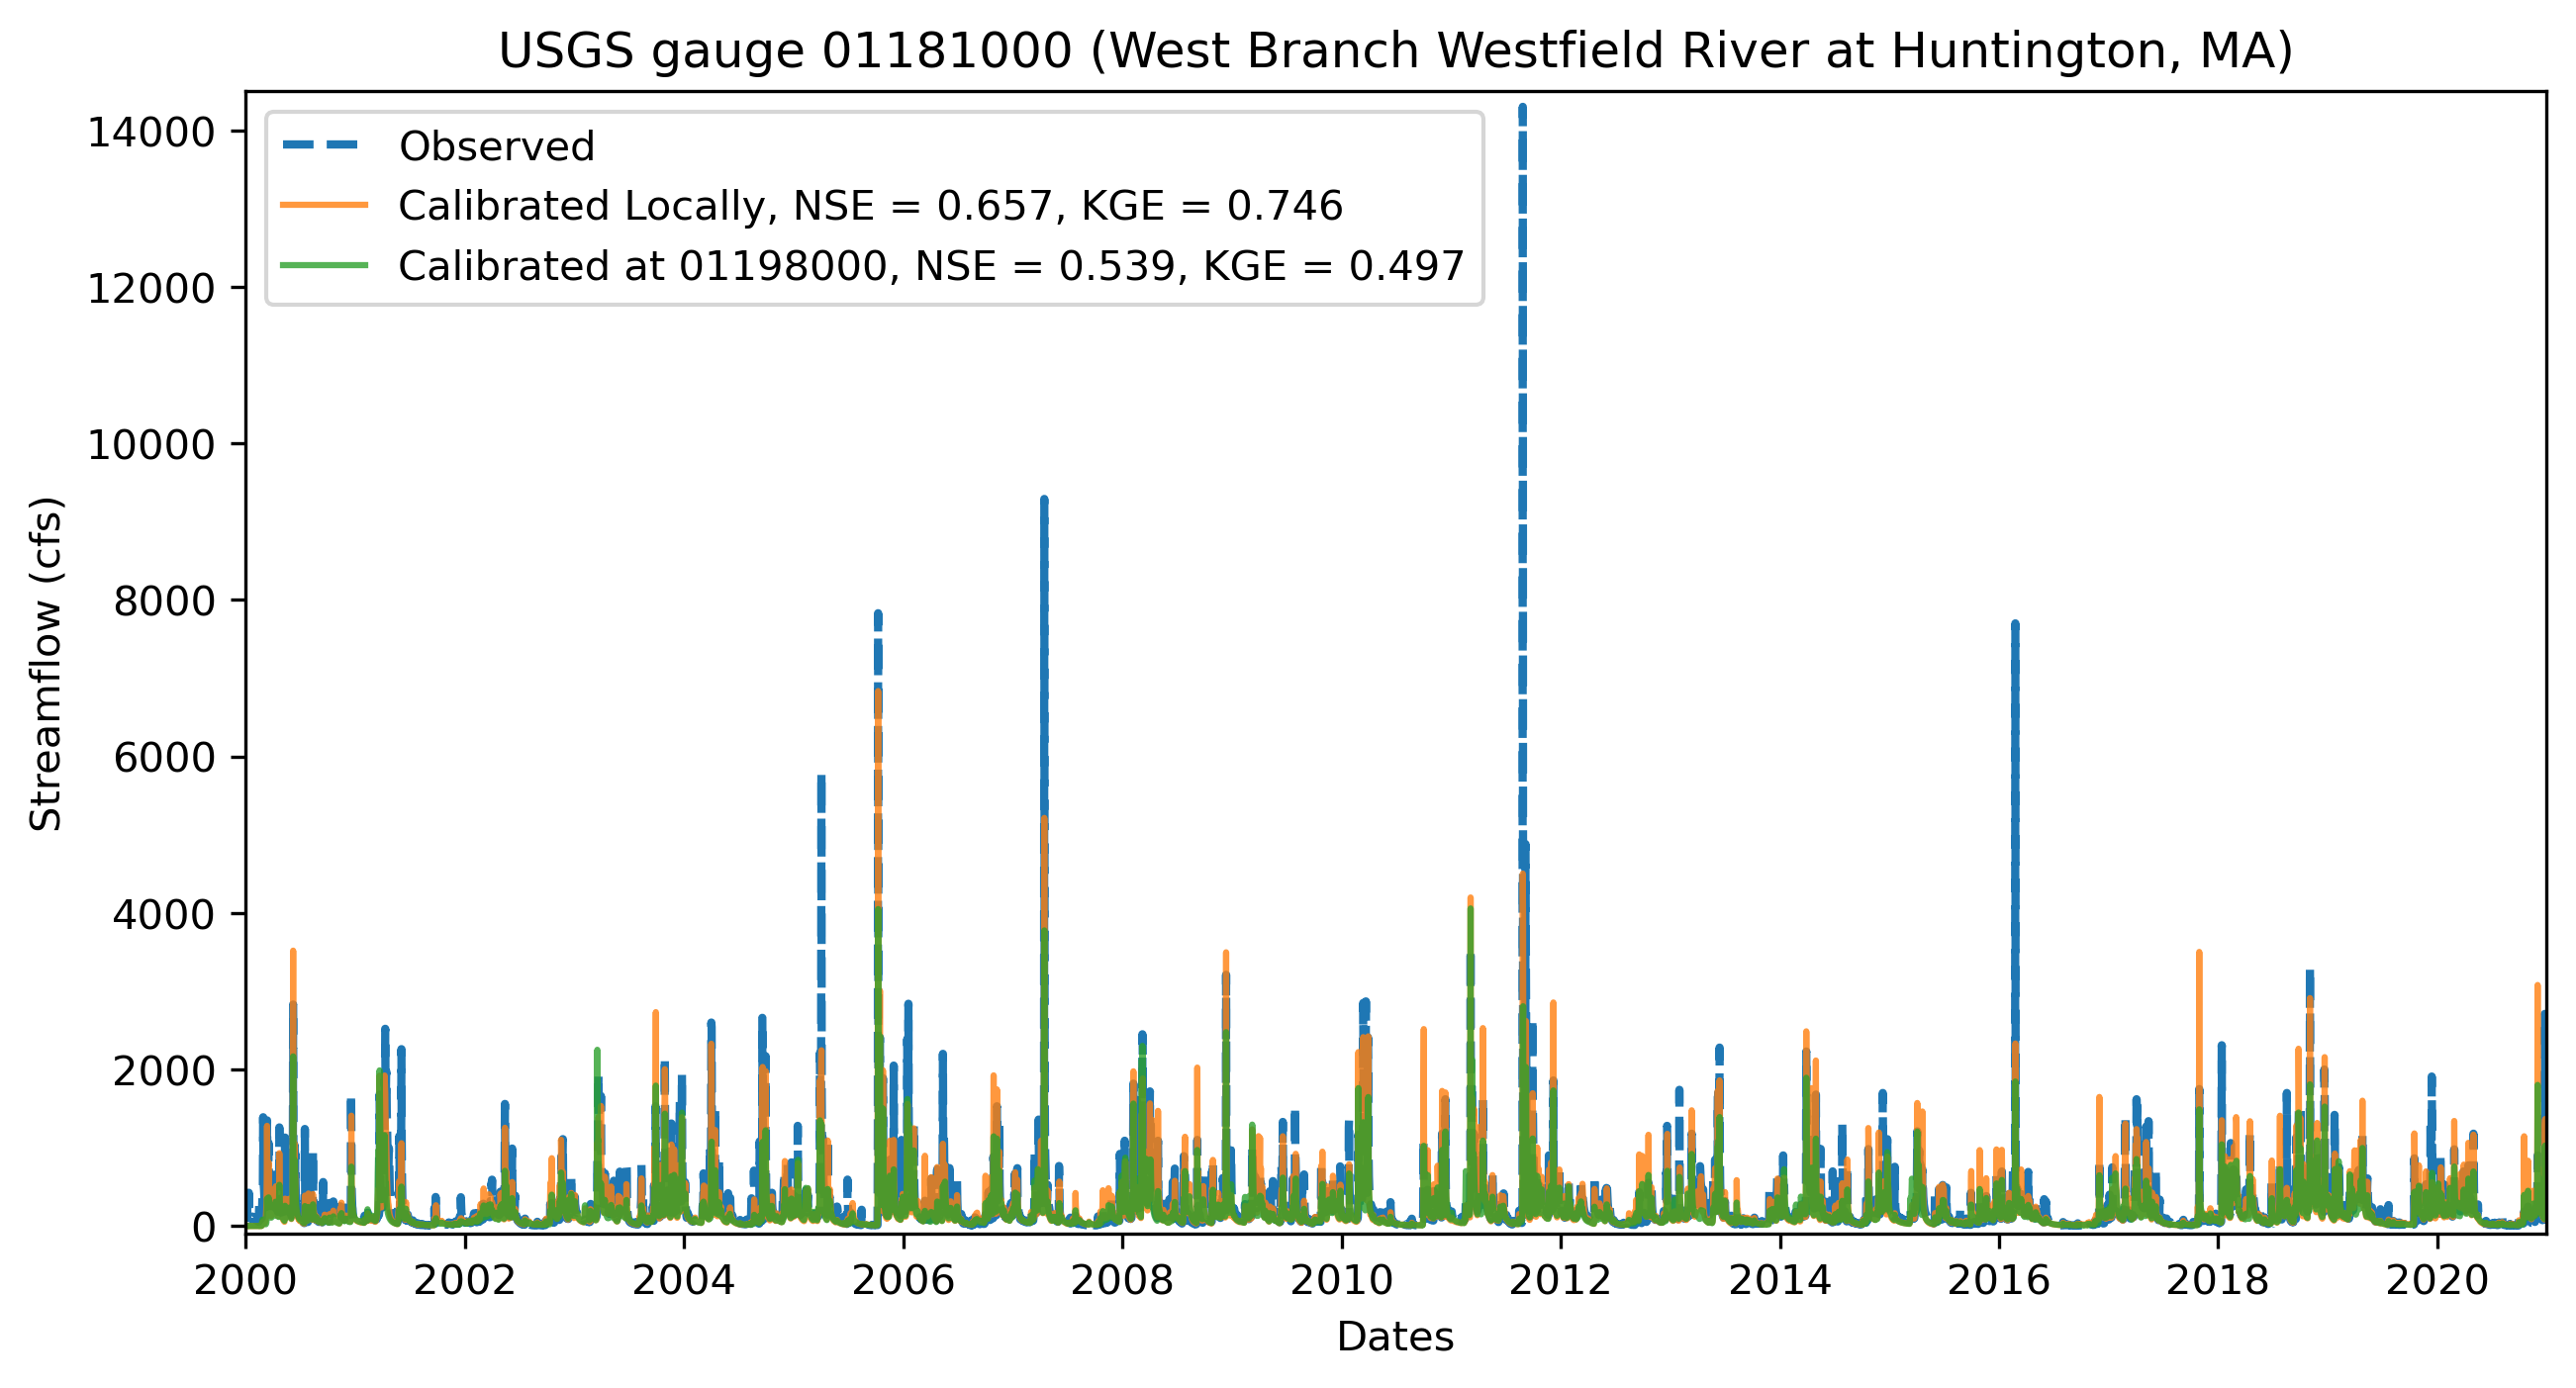

In [60]:
fig, axes = plt.subplots(# (2,1) 
                         figsize = (10, 5), 
                         dpi = 300)
axes.set_title("USGS gauge 01181000 (West Branch Westfield River at Huntington, MA)")

# plot in cfs
axes.plot(obsflow * gauge_area, label = 'Observed', linestyle = '--', linewidth = 2)
axes.plot(sim_flow_local * gauge_area, 
          label = 'Calibrated Locally, NSE = {NSE}, KGE = {KGE}'.format(NSE = calc_nse(obsflow.values.ravel(), sim_flow_local.values.ravel()).round(3), 
                                                              KGE = calc_kge(obsflow.values.ravel(), sim_flow_local.values.ravel()).round(3)),
         alpha = 0.8)
axes.plot(sim_flow_trans * gauge_area, 
          label = 'Calibrated at {cal_gauge}, NSE = {NSE}, KGE = {KGE}'.format(cal_gauge = HS_gauge, 
                                                                               NSE = calc_nse(obsflow.values.ravel(), sim_flow_trans.values.ravel()).round(3), 
                                                                               KGE = calc_kge(obsflow.values.ravel(), sim_flow_trans.values.ravel()).round(3)),
         alpha = 0.8)


# separate calibration and validation period
cal_val_date = sim_flow_local.index[100:] # first 100 days as warm up
cal_date = sim_flow_local.index[:int(len(cal_val_date) * 0.8)]
val_date = sim_flow_local.index[int(len(cal_val_date) * 0.8):]
#axes.fill_between(cal_date, -100, 14500, color = 'b', alpha = 0.3)
#axes.fill_between(val_date, -100, 14500, color = 'r', alpha = 0.3)

# axes.text(x =cal_date[int(len(cal_date)/3)], y = 12000 ,s = 'Calibration')


axes.set_xbound(sim_flow_local.index[0], sim_flow_local.index[-1])
axes.set_ybound(-100, 14500)
axes.set_xlabel('Dates')
axes.set_ylabel('Streamflow (cfs)')
axes.legend(loc = 'upper left')

In [61]:
# fig.savefig('docs/paper_1/parameter_transferring/01181000_validate.pdf', bbox_inches='tight')